In [1]:
import xarray as xr
import glob
import os
import regex as re
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar

In [44]:
rootdir = '/projects/SOCCOM/'
rootdir_ecco = rootdir+'scratch/gpfs/graemem/ecco/Version4/Release4/interp_monthly'
rootdir_sos = '/scratch/gpfs/graemem/en4/EN.4.2.2_regridded/'
rootdir_wmt = rootdir+'graemem/wmt/ecco/'
ppname = '*'
year = '*'
filename = '*_'+str(year)+'_*.nc'
pathstr = rootdir_ecco+'/*/'+str(year)+'/'+filename
paths = glob.glob(pathstr)
paths[0]

'/projects/SOCCOM/scratch/gpfs/graemem/ecco/Version4/Release4/interp_monthly/oceTAUX/2003/oceTAUX_2003_02.nc'

In [45]:
# Grab only the paths for the variables of interest
variables = ['oceFWflx','TFLUX','SALT','THETA','SFLUX']
reg = re.compile(r"\L<variables>", variables=variables)
pathsnow = list(filter(reg.search, paths))

In [46]:
pathsnow[0]

'/projects/SOCCOM/scratch/gpfs/graemem/ecco/Version4/Release4/interp_monthly/oceFWflx/2003/oceFWflx_2003_06.nc'

In [47]:
def preprocess(ds):
    if 'k' in ds.dims:
        ds = ds.isel(k=0).drop('k')
    return ds

In [48]:
ds = xr.open_mfdataset(pathsnow,preprocess=preprocess)
ds = (
    ds.chunk({'time':60})
      .assign_coords({'i':ds['longitude'],'j':ds['latitude']})
      .rename({'i':'lon','j':'lat'})
)
ds

<xarray.Dataset>
Dimensions:    (lon: 720, lat: 360, time: 312, nv: 2)
Coordinates:
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time       (time) datetime64[ns] 1992-01-16T12:00:00 ... 2017-12-16
    latitude   (lat) float64 dask.array<chunksize=(360,), meta=np.ndarray>
    longitude  (lon) float64 dask.array<chunksize=(720,), meta=np.ndarray>
    Z          float32 dask.array<chunksize=(), meta=np.ndarray>
    timestep   (time) int64 dask.array<chunksize=(60,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(60, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SALT       (time, lat, lon) float64 dask.array<chunksize=(60, 360, 720), meta=np.ndarray>
    SFLUX      (time, lat, lon) float64 dask.array<chunksize=(60, 360, 720), meta=np.ndarray>
    TFLUX      (time, lat, lon) float64 dask.array<chunksize=(60, 360, 720), meta=np.ndarray>
    THETA      (time, lat, lon) float64 dask.array<chunksize=(60, 360, 720), meta=np.ndarray>
    oceFWflx   (time, lat, lon) float64 dask.array<chunksize=(60, 360, 720), meta=np.ndarray>
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           50
    geospatial_vertical_units:    meter
    geospatial_vertical_max:      -5.0
    date_created:                 Thu Aug 22 18:48:45 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

In [49]:
ds_wmt = xr.Dataset()
# Calculate terms
ds_wmt['tos'] = ds['THETA']
ds_wmt['sos'] = ds['SALT']
ds_wmt['hfds'] = ds['TFLUX']
ds_wmt['wfo'] = ds['oceFWflx']
conv = 1e-3
ds_wmt['sfdsi'] = ds['SFLUX']*conv

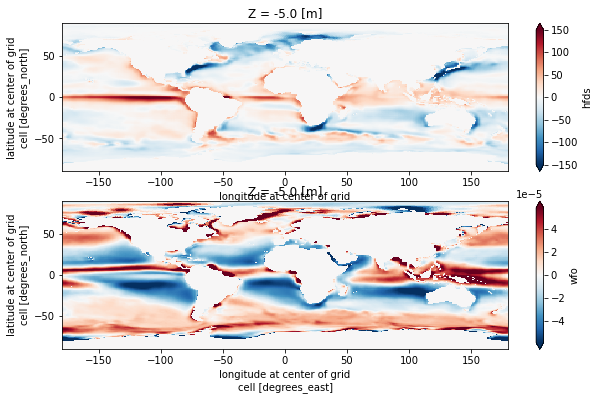

In [50]:
fig,(ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2)
ds_wmt['hfds'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax1,robust=True,vmin=-150,vmax=150,cmap='RdBu_r')
ds_wmt['wfo'].isel(time=slice(-240,-1)).mean('time').plot(ax=ax2,robust=True)

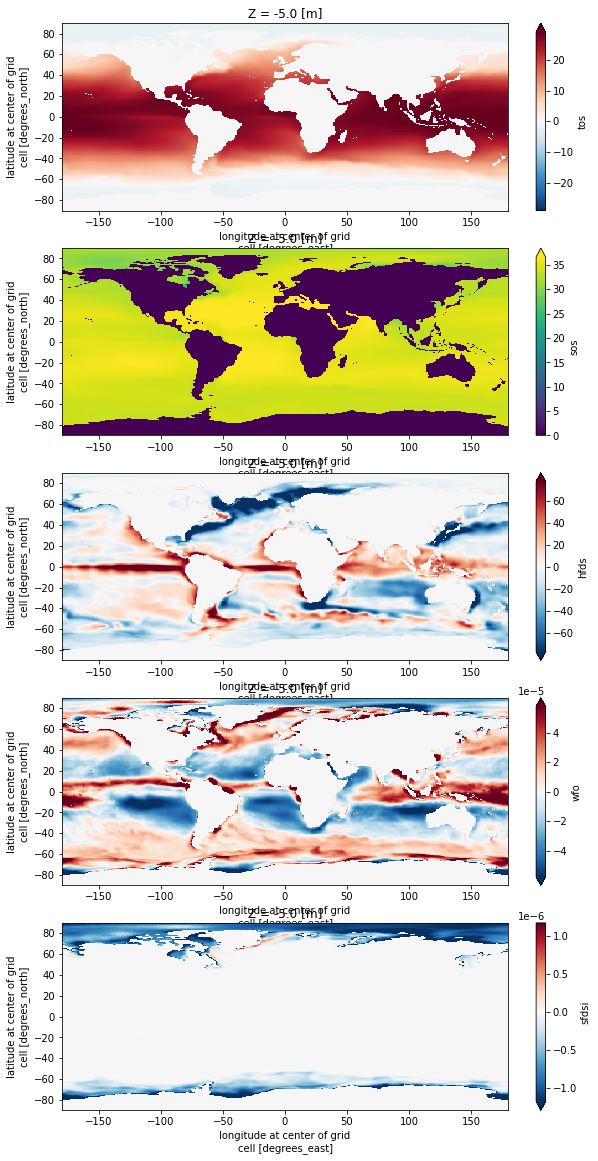

In [42]:
nv = len(ds_wmt.data_vars)
fig,ax = plt.subplots(figsize=(10,4*nv),nrows=nv)
for i,varname in enumerate(ds_wmt.data_vars):
    da = ds_wmt[varname].isel(time=slice(0,120)).mean('time')
    da.plot(ax=ax[i],robust=True)

In [52]:
with ProgressBar():
    ds_wmt.to_zarr(rootdir_wmt+'ecco.ecco.ds.zarr',mode='w')

[########################################] | 100% Completed | 83.99 s
